In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import skimage as ski
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score

In [2]:
os.chdir(r"C:\Users\TOMLU\Desktop\Data3888\individual")

In [3]:
RANDOM_SEED = 3888
# adjust this based on what strategy has been used to produce train/test folds + what image size
# code assumes image_dir/folds/classes/[images here] structure
IMAGE_DIR = os.path.join("projectdata", "images", "100_stratified4fold_1000per_seed3888")
BIG_IMAGE_PATH = os.path.join("projectdata", "metadata_code", "GSM7780153_Post-Xenium_HE_Rep1.ome.tif") 
UNCENTERED_DIR = os.path.join("projectdata", "images", "uncentred_ternary_224_stratified4fold_1000per_seed3888")
# can change fold list 
FOLDS = ["Q1", "Q2", "Q3", "Q4"]
CLASSES = ["Tumor", "Non-Tumor", "Empty"]
DESIRED_IMAGE_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TILE_SIZE = 100                     
STRIDE = 100  

np.random.seed(RANDOM_SEED)
print(sys.version)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [4]:
transform = transforms.Compose([
    transforms.Resize((DESIRED_IMAGE_SIZE, DESIRED_IMAGE_SIZE)),
    transforms.ToTensor()
])

In [5]:
def get_dataloaders_for_fold(test_fold):
    train_folds = [f for f in FOLDS if f != test_fold]

    train_datasets = []
    for fold in train_folds:
        path = os.path.join(IMAGE_DIR, fold)
        dataset = datasets.ImageFolder(root=path, transform=transform)
        train_datasets.append(dataset)

    test_path = os.path.join(IMAGE_DIR, test_fold)
    test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

    train_loader = DataLoader(ConcatDataset(train_datasets), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [19]:
def train(model, loader, optimizer, criterion): 
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [20]:
def evaluate(model, loader, criterion): 
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [ ]:
def load_quadrant_data(base_dir, quadrants):
    image_paths = []
    labels = []
    label_map = {"Empty": 0, "Non-tumor": 1, "Tumor": 2}

    for q in quadrants:
        for label_name in label_map:
            label_dir = os.path.join(base_dir, q, label_name)
            image_files = glob.glob(os.path.join(label_dir, "*.png")) + glob.glob(os.path.join(label_dir, "*.jpg"))
            image_paths.extend(image_files)
            labels.extend([label_map[label_name]] * len(image_files))

    return image_paths, labels


— Fold: Q1 —
Epoch 1/10 - Train Loss: 0.7216
Epoch 2/10 - Train Loss: 0.5190
Epoch 3/10 - Train Loss: 0.4822
Epoch 4/10 - Train Loss: 0.4532
Epoch 5/10 - Train Loss: 0.4285
Epoch 6/10 - Train Loss: 0.3816
Epoch 7/10 - Train Loss: 0.3463
Epoch 8/10 - Train Loss: 0.3105
Epoch 9/10 - Train Loss: 0.2765
Epoch 10/10 - Train Loss: 0.2241
Model saved to trained_CNN100_fold_Q1.pth
Accuracy (on uncentered Q1): 0.8082, F1-score: 0.8059
              precision    recall  f1-score   support

       Tumor       1.00      0.88      0.94       100
   Non-Tumor       0.72      0.94      0.82       500
       Empty       0.91      0.66      0.77       500

    accuracy                           0.81      1100
   macro avg       0.88      0.83      0.84      1100
weighted avg       0.84      0.81      0.81      1100



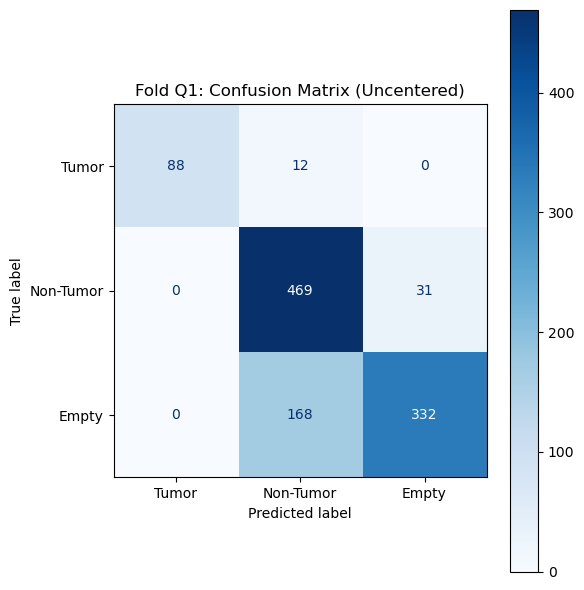


— Fold: Q2 —
Epoch 1/10 - Train Loss: 0.7866
Epoch 2/10 - Train Loss: 0.6412
Epoch 3/10 - Train Loss: 0.5630
Epoch 4/10 - Train Loss: 0.5259
Epoch 5/10 - Train Loss: 0.4587
Epoch 6/10 - Train Loss: 0.4504
Epoch 7/10 - Train Loss: 0.4255
Epoch 8/10 - Train Loss: 0.3822
Epoch 9/10 - Train Loss: 0.3490
Epoch 10/10 - Train Loss: 0.3335
Model saved to trained_CNN100_fold_Q2.pth
Accuracy (on uncentered Q2): 0.7891, F1-score: 0.7845
              precision    recall  f1-score   support

       Tumor       0.81      1.00      0.90       100
   Non-Tumor       0.71      0.91      0.80       500
       Empty       0.93      0.63      0.75       500

    accuracy                           0.79      1100
   macro avg       0.82      0.85      0.81      1100
weighted avg       0.82      0.79      0.78      1100



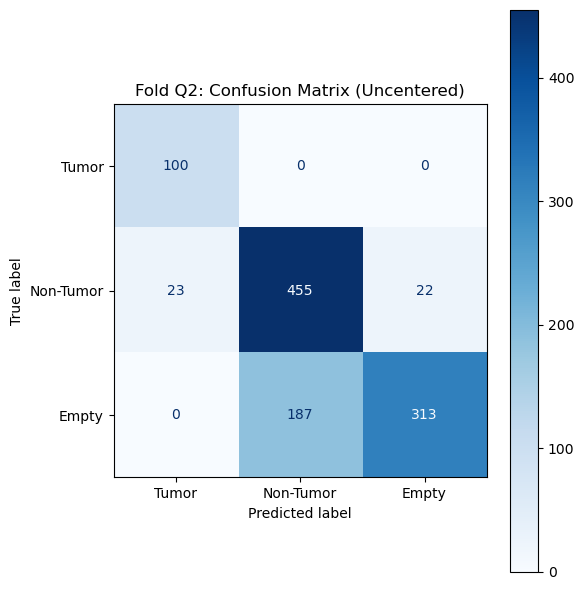


— Fold: Q3 —
Epoch 1/10 - Train Loss: 0.6898
Epoch 2/10 - Train Loss: 0.5007
Epoch 3/10 - Train Loss: 0.4446
Epoch 4/10 - Train Loss: 0.4074
Epoch 5/10 - Train Loss: 0.3864
Epoch 6/10 - Train Loss: 0.3442
Epoch 7/10 - Train Loss: 0.3038
Epoch 8/10 - Train Loss: 0.3078
Epoch 9/10 - Train Loss: 0.2439
Epoch 10/10 - Train Loss: 0.1918
Model saved to trained_CNN100_fold_Q3.pth
Accuracy (on uncentered Q3): 0.7427, F1-score: 0.7295
              precision    recall  f1-score   support

       Tumor       0.87      0.97      0.92       100
   Non-Tumor       0.65      0.94      0.77       500
       Empty       0.94      0.50      0.65       500

    accuracy                           0.74      1100
   macro avg       0.82      0.80      0.78      1100
weighted avg       0.80      0.74      0.73      1100



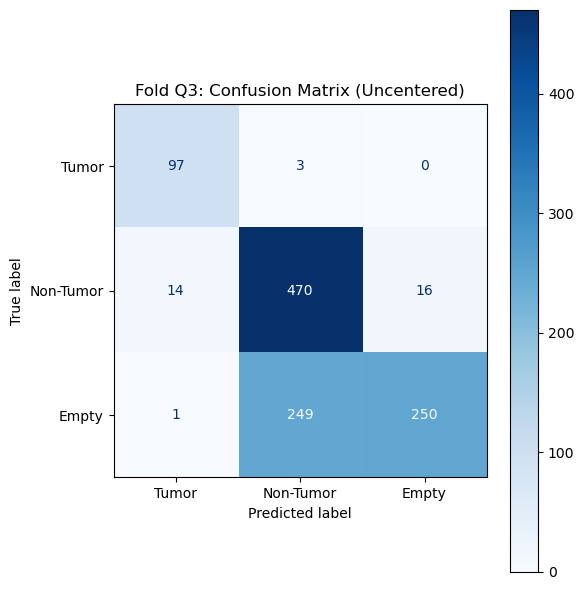


— Fold: Q4 —
Epoch 1/10 - Train Loss: 0.7777
Epoch 2/10 - Train Loss: 0.5667
Epoch 3/10 - Train Loss: 0.5298
Epoch 4/10 - Train Loss: 0.5028
Epoch 5/10 - Train Loss: 0.4704
Epoch 6/10 - Train Loss: 0.4564
Epoch 7/10 - Train Loss: 0.4253
Epoch 8/10 - Train Loss: 0.4058
Epoch 9/10 - Train Loss: 0.3740
Epoch 10/10 - Train Loss: 0.3399
Model saved to trained_CNN100_fold_Q4.pth
Accuracy (on uncentered Q4): 0.6118, F1-score: 0.5903
              precision    recall  f1-score   support

       Tumor       0.46      1.00      0.63       100
   Non-Tumor       0.57      0.80      0.67       500
       Empty       0.98      0.34      0.51       500

    accuracy                           0.61      1100
   macro avg       0.67      0.72      0.60      1100
weighted avg       0.75      0.61      0.59      1100



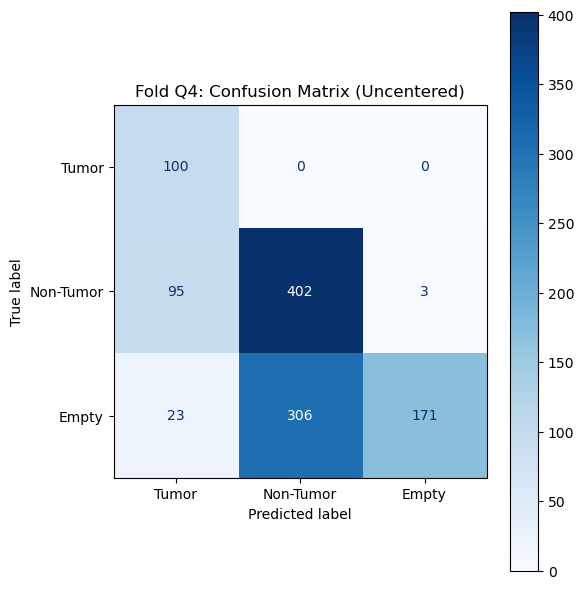

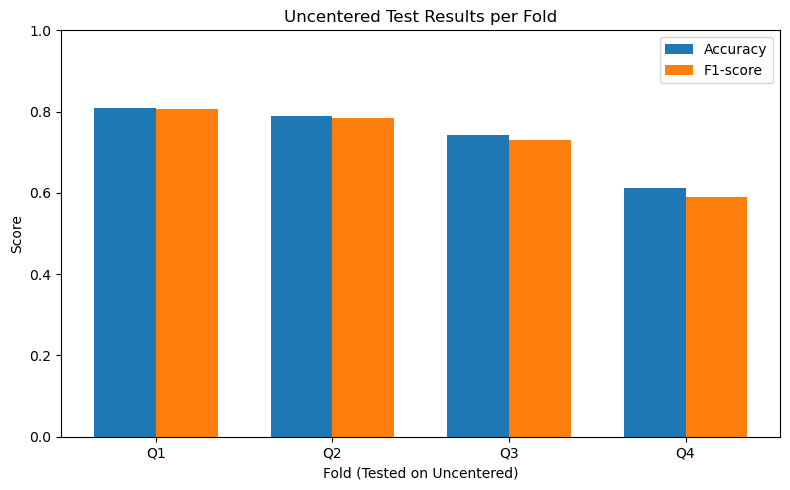

In [28]:
accuracies = [] 
f1_scores = []

for fold in FOLDS:
    print(f"\n— Fold: {fold} —")

    
    train_loader, _ = get_dataloaders_for_fold(fold)

    model = SimpleCNN(num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}")

    model_path = f"trained_CNN100_fold_{fold}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    
    uncentered_dir = os.path.join("projectdata", "images", "uncentred_ternary_224_stratified4fold_1000per_seed3888")
    test_paths, test_labels = load_quadrant_data(uncentered_dir, [fold])
    test_dataset = CustomImageDataset(test_paths, test_labels, transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"Accuracy (on uncentered {fold}): {acc:.4f}, F1-score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=CLASSES))

   
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES).plot(ax=ax, cmap='Blues')
    ax.set_title(f'Fold {fold}: Confusion Matrix (Uncentered)')
    plt.tight_layout()
    plt.show()


x = FOLDS
bar_width = 0.35
x_idx = np.arange(len(x))

plt.figure(figsize=(8, 5))
plt.bar(x_idx, accuracies, bar_width, label='Accuracy')
plt.bar(x_idx + bar_width, f1_scores, bar_width, label='F1-score')
plt.xticks(x_idx + bar_width / 2, x)
plt.xlabel('Fold (Tested on Uncentered)')
plt.ylabel('Score')
plt.title('Uncentered Test Results per Fold')
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
avg_acc = np.mean(accuracies)
avg_f1 = np.mean(f1_scores)

print(f"\nAverage Accuracy across folds: {avg_acc:.4f}")
print(f"Average F1-score across folds: {avg_f1:.4f}")


Average Accuracy across folds: 0.7380
Average F1-score across folds: 0.7276
